In [1]:
#hide
!pip install -Uqq fastbook

In [2]:
import fastbook
fastbook.setup_book()

In [3]:
from fastbook import *

In [4]:
path = untar_data(URLs.MNIST)

In [5]:
#hide
Path.BASE_PATH = path

We can see what's in this directory by using `ls`, a method added by fastai. This method returns an object of a special fastai class called `L`, which has all the same functionality of Python's built-in `list`, plus a lot more. One of its handy features is that, when printed, it displays the count of items, before listing the items themselves (if there are more than 10 items, it just shows the first few):

In [6]:
path.ls()

(#2) [Path('testing'),Path('training')]

The MNIST dataset follows a common layout for machine learning datasets: separate folders for the training set and the validation set (and/or test set). Let's see what's inside the training set:

In [7]:
(path/'training').ls()

(#10) [Path('training/5'),Path('training/6'),Path('training/4'),Path('training/1'),Path('training/9'),Path('training/7'),Path('training/3'),Path('training/2'),Path('training/8'),Path('training/0')]

There's a folder of 3s, and a folder of 7s. In machine learning parlance, we say that "3" and "7" are the *labels* (or targets) in this dataset. Let's take a look in one of these folders (using `sorted` to ensure we all get the same order of files):

# Raw pytorch

In [8]:
from PIL import Image
import numpy as np
import torch
import torch.nn as nn


In [9]:
n_samples = 1000

loaded_imgs = []
y = []

for number in (path/'training').ls():
    samples = number.ls().sorted()[:n_samples]
    loaded_imgs.extend([
        torch.from_numpy(np.asarray(Image.open(p)).flatten().astype(np.float32))
        for p in samples
    ])
    target_val = int(number.name)
    y.append(torch.Tensor([target_val for i in samples]))
x = torch.stack(loaded_imgs).to('cuda')
train_mean = x.mean()
train_std = x.std()
x = (x - train_mean) / train_std
y = torch.concat(y)[:, None].long().to('cuda')

print(x.shape, y.shape)


loaded_imgs = []
y_test = []

for number in (path/'testing').ls():
    samples = number.ls()
    loaded_imgs.extend([
        torch.from_numpy(np.asarray(Image.open(p)).flatten().astype(np.float32))
        for p in samples
    ])
    target_val = int(number.name)
    y_test.append(torch.Tensor([target_val for i in samples]))
x_test = torch.stack(loaded_imgs).to('cuda')
x_test = (x_test - train_mean) / train_std
y_test = torch.concat(y_test)[:, None].long().to('cuda')

print(x_test.shape, y_test.shape)

torch.Size([10000, 784]) torch.Size([10000, 1])
torch.Size([10000, 784]) torch.Size([10000, 1])


In [11]:
x.device

device(type='cuda', index=0)

In [18]:
class LogisticRegression:
    def __init__(self, input_size, output_size, n_layers, hidden_layer_size):
        self.parameters = []
        self.n_layers = n_layers
        prev_layer_output = input_size
        for layer in range(n_layers):
            if layer == n_layers-1:
                weight = self._initialize_param((prev_layer_output, output_size))
                bias = self._initialize_param((output_size,))
            else:
                weight = self._initialize_param((prev_layer_output, hidden_layer_size))
                bias = self._initialize_param((hidden_layer_size,))
            prev_layer_output = hidden_layer_size
            self.parameters.append((weight, bias))
        
    def _initialize_param(self,size):
        p = (torch.randn(size)/np.sqrt(size[0])).to('cuda')
        p.requires_grad_()
        p.retain_grad()
        return p
    
    def _update_param(self, p, lr):
        with torch.no_grad():
            p -= lr * p.grad
            p.grad.zero_()
        
    def forward(self, x):
        layer = x
        #print(layer)
        for i, (w,b) in enumerate(self.parameters):
            layer = torch.add(torch.mm(layer, w), b)
            #print(layer)
            if (i+1)==self.n_layers:
                layer_exp = torch.exp(layer)
                #print(layer_exp)
                #print(layer_exp.sum(keepdim=True, axis=1))
                layer = layer_exp / layer_exp.sum(axis=1, keepdim=True)
            else:
                layer.clamp_(min=0)
        #print(layer)
        return layer
    
    def predict(self, x):
        with torch.no_grad():
            return self.forward(x).argmax(axis=1, keepdim=True)
        
    def accuracy(self, x, y):
        preds = self.predict(x)
        return (m.predict(x)==y).cpu().numpy().mean()
    
    def backward(self, x, y_true):
        loss = self.loss(x, y_true)
        loss_value = loss.item()
        loss.backward()
        return loss_value
        
    def update_parameters(self, lr):
        for (w,b) in self.parameters:
            self._update_param(w, lr)
            self._update_param(b, lr)
    
    def loss(self, x, y_true):
        y_pred = self.forward(x)
        loss_total = 0
        for y_pred_i, y_true_i in zip(y_pred, y_true):
            loss_total += -torch.log(y_pred_i[y_true_i])
        return loss_total/len(y_pred)
        

In [19]:
m = LogisticRegression(
    input_size=x.shape[1],
    output_size=10,
    n_layers=2,
    hidden_layer_size=10
)
m.accuracy(x,y)

# with torch.no_grad():
#     print('Forward')
#     print(m.forward(x)[:5])

# print('Loss debug')
# with torch.no_grad():
#     loss_total = 0
#     for y_pred_i, y_true_i in zip(m.forward(x)[:5], y[:5]):
#         print(y_pred_i,y_true_i)
#         print(y_pred_i[y_true_i])
#         print(-torch.log(y_pred_i[y_true_i]))
#         loss_total += -torch.log(y_pred_i[y_true_i])
#         print(loss_total)
#         print()

0.114

In [22]:
m = LogisticRegression(
    input_size=x.shape[1],
    output_size=10,
    n_layers=1,
    hidden_layer_size=10
)

n_epochs = 100
lr = 1e-2
log = []
log_freq = 1
print_freq = 5
for epoch in range(n_epochs):
    train_loss = m.backward(x, y)
    m.update_parameters(lr)
    if epoch%log_freq == 0:
        with torch.no_grad():
            test_loss = m.loss(x_test, y_test).item()
            train_accuracy = m.accuracy(x, y)
            test_accuracy = m.accuracy(x_test, y_test)
        log.append([epoch, train_loss, train_accuracy, test_loss, test_accuracy])
        if epoch%print_freq==0:
            print(f"{epoch: >5} train loss={train_loss:.4f}; train acc={train_accuracy:.4f}; test loss={test_loss:.4f}; test accuracy={test_accuracy:.4f}")

    0 train loss=2.7130; train acc=0.1462; test loss=2.5507; test accuracy=0.1369
    5 train loss=2.0671; train acc=0.3018; test loss=1.9733; test accuracy=0.2925
   10 train loss=1.7021; train acc=0.4576; test loss=1.6205; test accuracy=0.4675
   15 train loss=1.4592; train acc=0.5831; test loss=1.3840; test accuracy=0.5980
   20 train loss=1.2892; train acc=0.6511; test loss=1.2188; test accuracy=0.6666
   25 train loss=1.1652; train acc=0.6928; test loss=1.0984; test accuracy=0.7107
   30 train loss=1.0714; train acc=0.7190; test loss=1.0075; test accuracy=0.7391
   35 train loss=0.9981; train acc=0.7372; test loss=0.9364; test accuracy=0.7617
   40 train loss=0.9392; train acc=0.7541; test loss=0.8794; test accuracy=0.7791
   45 train loss=0.8909; train acc=0.7656; test loss=0.8327; test accuracy=0.7892
   50 train loss=0.8505; train acc=0.7768; test loss=0.7937; test accuracy=0.7966
   55 train loss=0.8161; train acc=0.7843; test loss=0.7605; test accuracy=0.8035
   60 train loss

## 1 layer, 10 hidden

<AxesSubplot:xlabel='epoch'>

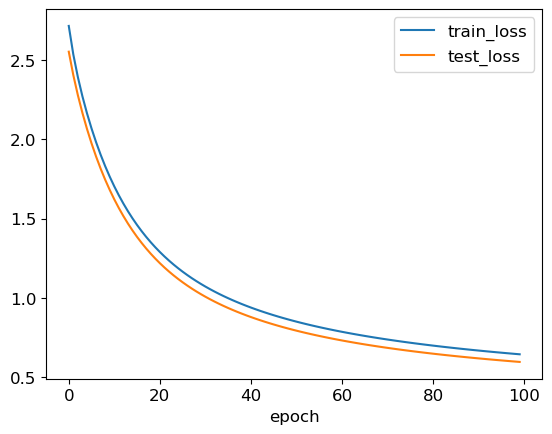

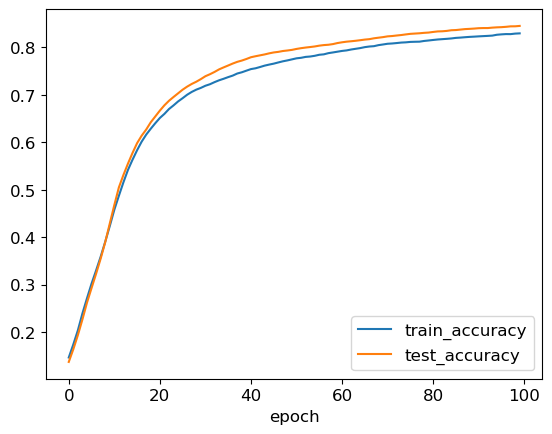

In [23]:
import pandas as pd
log = pd.DataFrame(log, columns=['epoch','train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
log.set_index('epoch')[['train_loss','test_loss']].plot()
log.set_index('epoch')[['train_accuracy','test_accuracy']].plot()

## 2 layer, 10 hidden

In [ ]:
m = LogisticRegression(
    input_size=x.shape[1],
    output_size=10,
    n_layers=2,
    hidden_layer_size=10
)

n_epochs = 100
lr = 1e-2
log = []
log_freq = 1
print_freq = 5
for epoch in range(n_epochs):
    train_loss = m.backward(x, y)
    m.update_parameters(lr)
    if epoch%log_freq == 0:
        with torch.no_grad():
            test_loss = m.loss(x_test, y_test).item()
            train_accuracy = m.accuracy(x, y)
            test_accuracy = m.accuracy(x_test, y_test)
        log.append([epoch, train_loss, train_accuracy, test_loss, test_accuracy])
        if epoch%print_freq==0:
            print(f"{epoch: >5} train loss={train_loss:.4f}; train acc={train_accuracy:.4f}; test loss={test_loss:.4f}; test accuracy={test_accuracy:.4f}")

    0 train loss=2.5705; train acc=0.0916; test loss=2.4800; test accuracy=0.0923
    5 train loss=2.2637; train acc=0.1629; test loss=2.2278; test accuracy=0.1634
   10 train loss=2.1382; train acc=0.2235; test loss=2.1048; test accuracy=0.2321
   15 train loss=2.0403; train acc=0.2755; test loss=2.0061; test accuracy=0.2835


In [ ]:
import pandas as pd
log = pd.DataFrame(log, columns=['epoch','train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
log.set_index('epoch')[['train_loss','test_loss']].plot()
log.set_index('epoch')[['train_accuracy','test_accuracy']].plot()

## 4 layer, 10 hidden

In [ ]:
m = LogisticRegression(
    input_size=x.shape[1],
    output_size=10,
    n_layers=4,
    hidden_layer_size=10
)

n_epochs = 100
lr = 1e-2
log = []
log_freq = 1
print_freq = 5
for epoch in range(n_epochs):
    train_loss = m.backward(x, y)
    m.update_parameters(lr)
    if epoch%log_freq == 0:
        with torch.no_grad():
            test_loss = m.loss(x_test, y_test).item()
            train_accuracy = m.accuracy(x, y)
            test_accuracy = m.accuracy(x_test, y_test)
        log.append([epoch, train_loss, train_accuracy, test_loss, test_accuracy])
        if epoch%print_freq==0:
            print(f"{epoch: >5} train loss={train_loss:.4f}; train acc={train_accuracy:.4f}; test loss={test_loss:.4f}; test accuracy={test_accuracy:.4f}")

In [ ]:
import pandas as pd
log = pd.DataFrame(log, columns=['epoch','train_loss', 'train_accuracy', 'test_loss', 'test_accuracy'])
log.set_index('epoch')[['train_loss','test_loss']].plot()
log.set_index('epoch')[['train_accuracy','test_accuracy']].plot()